In [1]:
#Загружаем наш дата сет. Мы имеем дата сет из 10 колонок (Age, Sex, ALP, ALT, AST, BIL, CHE, CHOL, CREA, Category) и 615 строк. Есть как числовые, так и качественные переменные. Крайний столбец Category выступает как классификатор.

In [1]:
# Загружаем необходимые библиотеки для начала работы (Numpy, Matplotlib.pyplot ,Pandas)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Загружаем дата сет в формате сsv, разделитель запятые.
df = pd.read_csv('cont.csv', sep=',' )

In [3]:
# Проверяем как загрузился дата сет. Сразу видно присутствие NaN в столбцах
df

,Age,Sex,ALP,ALT,AST,BIL,CHE,CHOL,CREA,Category
0,32,m,52.5,7.7,22.1,7.5,6.93,3.23,106.0,0
1,32,m,70.3,18.0,24.7,3.9,11.17,4.80,74.0,0
2,32,m,74.7,36.2,52.6,6.1,8.84,5.20,86.0,0
3,32,m,52.0,30.6,22.6,18.9,7.33,4.74,80.0,0
4,32,m,74.1,32.6,24.8,9.6,9.15,4.32,76.0,0
...,...,...,...,...,...,...,...,...,...,...
610,62,f,416.6,5.9,110.3,50.0,5.57,6.30,55.7,1
611,64,f,102.8,2.9,44.4,20.0,1.54,3.02,63.0,1
612,64,f,87.3,3.5,99.0,48.0,1.66,3.63,66.7,1
613,46,f,NaN,39.0,62.0,20.0,3.56,4.20,52.0,1


In [4]:
# Проверяем и заменяем пропуски в числовых столбцах дата сета.
def fill_missing_num(x):
    num_var = list(x._get_numeric_data().columns)
    for col_names in num_var:        
        prep_med = SimpleImputer(missing_values=np.nan, strategy='mean')
        prep_med.fit(x[num_var])
        x[num_var] = prep_med.transform(x[num_var])
    return(x)

In [5]:
# Заполняем значения NaN с помощью SimpleImputer.
from sklearn.impute import SimpleImputer
df = fill_missing_num(df)

In [6]:
# Производим кодирование всех качественных переменных, в нашем случае только столбец Sex.
def encoding_char(x):
    char_var = list(set(x.columns) - set(x._get_numeric_data().columns))
    for col_names in char_var:
        f = pd.factorize(x[col_names])
        x[col_names] = pd.factorize(x[col_names])[0]
    return(x)

In [7]:
df = encoding_char(df)

In [8]:
# Делим наш дата сет на обучающую и тестирующую выборку в пропорции 20/80.
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

In [9]:
# Производим шкалирование наших данных без нашей эдогенной переменной Category.
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler().fit(X_train)
X_train = sc_X.transform(X_train)
X_test = sc_X.transform(X_test)

In [10]:
# Строим базовую модель и смотрим на полученный отчет. Можно сделать вывод, что значимых перменных только две, это х4 (ALT) и х5 (AST). Будем использовать их для построения наших классификаторов.
import statsmodels.api as sm
lr = sm.Logit(y_train, X_train).fit()
print(lr.summary2())

Optimization terminated successfully.
         Current function value: 0.312738
         Iterations 8
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.214     
Dependent Variable: y                AIC:              325.7338  
Date:               2020-11-23 11:23 BIC:              363.5201  
No. Observations:   492              Log-Likelihood:   -153.87   
Df Model:           8                LL-Null:          -195.80   
Df Residuals:       483              LLR p-value:      8.1273e-15
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     8.0000                                       
--------------------------------------------------------------------
       Coef.     Std.Err.       z       P>|z|      [0.025     0.975]
--------------------------------------------------------------------
x1     0.0023      0.1505     0.0155    0.9877    -0.2927     0.2973
x2     0.1901      0.1652     1.1504    0.2500    -0.1

In [11]:
# Automatic Feature Selection
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
estimator=LogisticRegression(random_state=123)
selector=RFECV(estimator, step=1)
selector=selector.fit(X_train, y_train)
print(selector.n_features_)
print(selector.support_)
print(selector.ranking_)

4
[False False False False  True  True False  True  True]
[4 6 2 3 1 1 5 1 1]


In [12]:
# Selected Features
selected_columns=[]
for i in range(len(X_train[0])):
    if selector.support_[i]==1:
        selected_columns.append(i)
print(selected_columns)
print('№\tIndex\tFeature')
i=0
for column in selected_columns:
    print(str(i)+'\t'+str(column)+'\t'+str(df.columns[column]))
    i=i+1

[4, 5, 7, 8]
№	Index	Feature
0	4	AST
1	5	BIL
2	7	CHOL
3	8	CREA


In [13]:
X_train_select=X_train[:, selected_columns]
X_test_select=X_test[:, selected_columns]

In [14]:
# Остлавляем только значимые переменные.
X_train = X_train[:,[3,4]]
X_test = X_test[:,[3,4]]

In [15]:
# Обучаем модель логистической регрессии.
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state = 13).fit(X_train, y_train)

In [16]:
# Делаем прогноз на тестовой выборке. Уровень качества модели очень высок, превышает 95%, то  есть 95% объектов распознано верно.
y_pred = lr.predict(X_test)
lr.score(X_test,y_test)

0.959349593495935

In [17]:
# Строим таблицу сопряженности. Можно сделать вывод, что 5 положительных случая ложно определены как отрицательные. 
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[108   0]
 [  5  10]]


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


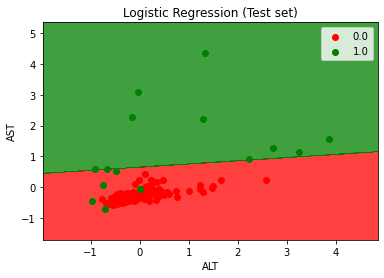

In [18]:
# Строим область значений. Они отделяются линейно. Зелёные точки - больные люди, красные точки - здоровые. Люди с повышенным значением AST более склонны к болезни. 
from matplotlib.colors import ListedColormap
X_set, y_set = X_test, y_test
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, lr.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green'))(i), label = j)
plt.title('Logistic Regression (Test set)')
plt.xlabel('ALT')
plt.ylabel('AST')
plt.legend()
plt.show()

In [19]:
# Устанавливаем необходимые пакеты Keras.
import keras
from keras.models import Sequential
from keras.layers import Dense

In [32]:
# Строим нейронную сеть прямой передачи сигнала. На входном слое 8 нейрона (усложнее). Используем функцию relu, которая позволит учесть наличие линейнносоти в исходных данных. На втором слое выбирем 1 нейрон используя сигмоидальную функцию. 
cnn = Sequential()
cnn.add(Dense(units = 8,  activation = 'relu', input_dim = 2))
cnn.add(Dense(units = 1,  activation = 'sigmoid'))
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [33]:
# Обучаем нейронную сеть в течении 100 эпох.
cnn.fit(X_train, y_train, epochs = 100, batch_size = 8)

Epoch 1/100
62/62 [==============================] - 0s 479us/step - loss: 0.7554 - accuracy: 0.2683
Epoch 2/100
62/62 [==============================] - 0s 466us/step - loss: 0.6316 - accuracy: 0.8374
Epoch 3/100
62/62 [==============================] - 0s 460us/step - loss: 0.5462 - accuracy: 0.8679
Epoch 4/100
62/62 [==============================] - 0s 466us/step - loss: 0.4816 - accuracy: 0.8679
Epoch 5/100
62/62 [==============================] - 0s 466us/step - loss: 0.4291 - accuracy: 0.8740
Epoch 6/100
62/62 [==============================] - 0s 483us/step - loss: 0.3866 - accuracy: 0.8862
Epoch 7/100
62/62 [==============================] - 0s 486us/step - loss: 0.3521 - accuracy: 0.8882
Epoch 8/100
62/62 [==============================] - 0s 451us/step - loss: 0.3243 - accuracy: 0.8923
Epoch 9/100
62/62 [==============================] - 0s 466us/step - loss: 0.3017 - accuracy: 0.8943
Epoch 10/100
62/62 [==============================] - 0s 464us/step - loss: 0.2832 - accura

In [34]:
# Строим прогноз на тестовой выборке.
y_pred = cnn.predict(X_test)
y_pred = (y_pred > 0.5)

In [35]:
# Строим таблицу сопряженности. Можно сделать вывод, что 3 положительных случая ложно определены как отрицательные, что уже лучше, чем модель построенная ранее.
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[108   0]
 [  3  12]]


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


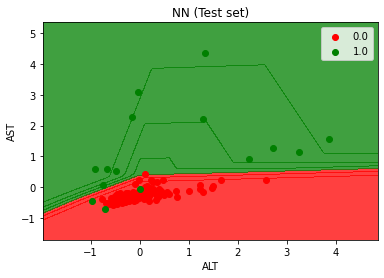

In [36]:
# Строим область значений. Они отделяются менее линейно в сравнении с предыдущей моделью. Однако после усложения модели после увеличения входных нейронов с 2 до 8, качество модели улучшилось. 
from matplotlib.colors import ListedColormap
X_set, y_set = X_test, y_test
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, cnn.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green'))(i), label = j)
plt.title('NN (Test set)')
plt.xlabel('ALT')
plt.ylabel('AST')
plt.legend()
plt.show()